<a href="https://colab.research.google.com/github/mdavydenko/tf2demo/blob/master/tf2fwi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Same as in the previous demo, dont forget to go to:
 *Tools -> Preferences -> Power level*
and select there  *Many power*

Then, we upgrade tensorflow to 2.0.0-alpha0 version and initialize the code

In [3]:
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

# For a specific version:
!pip install tensorflow==2.0.0-alpha0 

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from tensorflow.linalg import expm, sqrtm
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import math as m


from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

from tensorflow import keras
from datetime import datetime

from scipy import signal

import numpy as np
import matplotlib.pyplot as plt
import math as m

def ricker(f, length=0.128, dt=0.001,t0=0.05):
    t = np.arange(0,length/2+(length-dt)/2, dt)
    t = t - t0
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y

Name: tensorflow
Version: 2.0.0a0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: absl-py, gast, numpy, six, astor, termcolor, grpcio, keras-applications, keras-preprocessing, google-pasta, tf-estimator-nightly, wheel, tb-nightly, protobuf
Required-by: stable-baselines, magenta, fancyimpute
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.0.0a0)


Initialize model parameters and create TF variables:

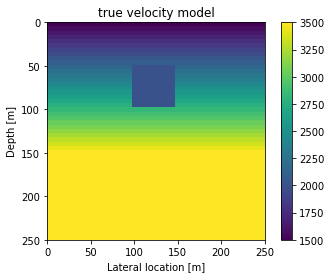

In [13]:
ntap=15
nx=51
ns=10
ds=round(nx/ns)
nz=51
dx=5
dz=5
nt=256
dt=0.008
dt_mod=0.001
df=1/nt/dt
mode=0
f = 25 # A low wavelength of 25 Hz
t, w = ricker(f,nt*dt_mod,dt_mod)
c=3500
vel = 1.0*c*np.ones([nz,nx],dtype=np.float32)

ctrue = c*np.ones([nz,nx],dtype=np.float32)
gas = np.zeros([nz,nx],dtype=np.float32)
for ix in range(nx):
    ctrue[ix,0:30]=1500+np.arange(0,2000,2000/30)
ctrue[20:30,10:20]=2000
    
vel=ctrue
plt.title('true velocity model')
plt.imshow(np.transpose(vel),aspect='equal',extent=[0,dx*(nx-1),dz*(nz-1),0])
plt.axis([0,(nx-1)*dx,(nz-1)*dz,0])
plt.xlabel('Lateral location [m]')
plt.ylabel('Depth [m]')
plt.colorbar()
plt.show()

k=np.zeros([3,3],dtype=np.float32)
k[0,1]=k[1,0]=k[2,1]=k[1,2]=1;
k[1,1]=-4;

C   =  tf.Variable(vel,name="velocity")
K   =  tf.Variable(k,name="kernel")
C0   = tf.Variable(vel)

p_mod = np.zeros([ns,nx,nz,nt],dtype=np.float32)
p_wav = np.zeros([ns,nx,nz,nt],dtype=np.float32)

for si in range(ns):
    p_wav[si,si*ds,1,:]=w

P = tf.Variable(p_wav,name="wavefield")


Lets define the forward modelling operator (time-domain acoustic finite-differece modelling) and create some data:

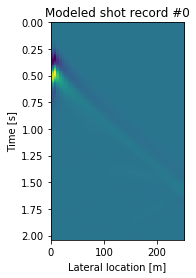

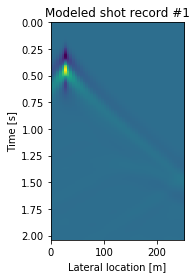

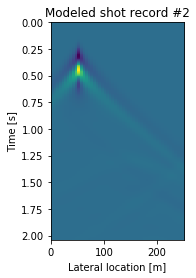

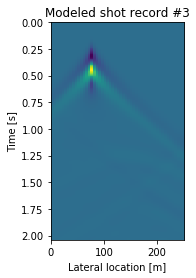

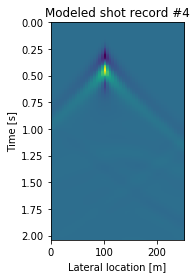

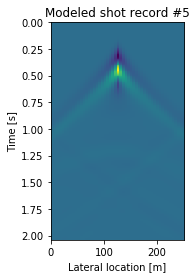

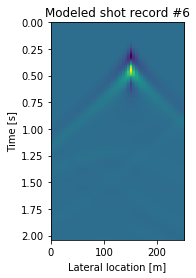

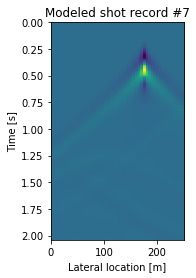

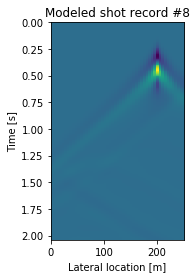

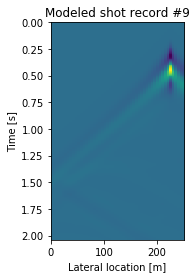

In [15]:
#@tf.function
def fd(p,C,dt,dx):
    nt=p.shape[3]
    ns=p.shape[0]
    nx=p.shape[1]
    nz=p.shape[2]
    p0 = np.zeros([ns,nx,nz,1],dtype=np.float32)
    p1 = np.zeros([ns,nx,nz,1],dtype=np.float32)
    p2 = np.zeros([ns,nx,nz,1],dtype=np.float32)
    p_out = np.zeros([ns,nx,nz,nt],dtype=np.float32)
    Pm=p0
    for it in range(nt-1):
        p1=p1+tf.reshape(p[:,:,:,it],[ns,nx,nz,1])
        p2=-p0+2*p1+tf.nn.conv2d(tf.reshape(p1,[ns,nx,nz,1]),tf.reshape(K,[3,3,1,1]),[1, 1, 1, 1],"SAME")*tf.reshape(C,[1,nx,nz,1])*tf.reshape(C,[1,nx,nz,1])*dt*dt/dx/dx
        p2top=(p1[:,:,1,:]-p1[:,:,0,:])*C[0,0]*dt/dx+p1[:,:,0,:]
        p2bot=(p1[:,:,nz-2,:]-p1[:,:,nz-1,:])*C[nz-1,nz-1]*dt/dx+p1[:,:,nz-1,:]
        p2lef=(p1[:,1,:,:]-p1[:,0,:,:])*C[0,0]*dt/dx+p1[:,0,:,:]
        p2rig=(p1[:,nz-2,:,:]-p1[:,nz-1,:,:])*C[nz-1,nz-1]*dt/dx+p1[:,nx-1,:,:]

        a, b, c = tf.split(p2, [1, nz-2, 1], 2)
        p2=tf.concat([tf.reshape(p2top,[ns,nx,1,1]),b,tf.reshape(p2bot,[ns,nx,1,1])],axis=2)
        a, b, c = tf.split(p2, [1, nz-2, 1], 1)
        p2=tf.concat([tf.reshape(p2lef,[ns,1,nz,1]),b,tf.reshape(p2rig,[ns,1,nz,1])],axis=1)

        Pm=tf.concat([Pm,p2],3)
        p0=p1
        p1=p2
        
    Pm=tf.reshape(Pm,[ns,nx,nz,nt])
    return Pm

Pobs=fd(P,C,dt_mod,dx)
for si in range(ns):
    plt.imshow(np.transpose(Pobs[si,:,0,:].numpy()),extent=[0,dx*(nx-1),dt*(nt-1),0],aspect=200)
    plt.axis([0,(nx-1)*dx,(nt-1)*dt,0])
    plt.xlabel('Lateral location [m]')
    plt.ylabel('Time [s]')
    plt.title('Modeled shot record #'+str(si))
    plt.show()


Next, we make initial model (by excluding anomaly) and check the FWI 🍌 gradient 🐰

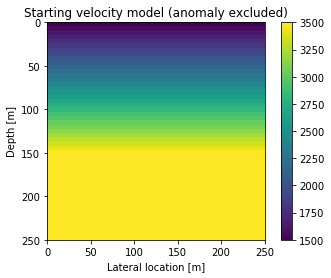

(51, 51)


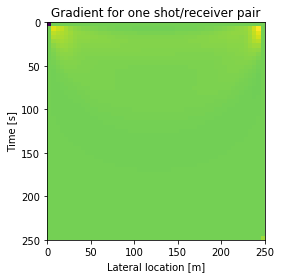

In [25]:
ctrue = c*np.ones([nz,nx],dtype=np.float32)
for ix in range(nx):
    ctrue[ix,0:30]=1500+np.arange(0,2000,2000/30)
C   =  tf.Variable(ctrue,name="velocity")

plt.title('Starting velocity model (anomaly excluded)')
plt.imshow(np.transpose(C.numpy()),aspect='equal',extent=[0,dx*(nx-1),dz*(nz-1),0])
plt.axis([0,(nx-1)*dx,(nz-1)*dz,0])
plt.xlabel('Lateral location [m]')
plt.ylabel('Depth [m]')
plt.colorbar()
plt.show()

clip=0.01



with tf.GradientTape() as tape:
  Pmod=fd(P,C,dt_mod,dx)
  Res=Pobs-Pmod
  #print(Res.shape)
  A=tf.signal.rfft(Pobs)
  B=tf.signal.rfft(Pmod)

  p_msk = np.zeros([ns,nx,nz,nt],dtype=np.float32)
  p_msk_z = np.zeros([ns,nx,nz,round(nt/2)+1],dtype=np.complex64)
  p_msk[0,50,1,:]=1##s-x-z-t
  p_msk_z[0,50,1,:]=1##s-x-z-f
  Pmask = tf.Variable(p_msk)
  Pmask_z = tf.Variable(p_msk_z)

  gradmode=0

  loss=tf.reduce_mean(Pmask_z*(A-B)*tf.math.conj(A-B))
  plt.title('Gradient L2')
  
grad=tape.gradient(loss,C)
print(grad.shape)
im1=plt.imshow(np.real(np.transpose(grad.numpy())),extent=[0,dx*(nx-1),dz*(nz-1),0],aspect='equal')
plt.axis([0,(nx-1)*dx,(nz-1)*dz,0])
plt.xlabel('Lateral location [m]')
plt.ylabel('Time [s]')
plt.title('Gradient for one shot/receiver pair')
plt.show()



In the previous example we've applied mask on the data-misfit objective function (only one source/receiver pair). Next we restirct mask only for the surface but for all shot/receiver pairs. You can also check various objective functions by changing *gradmode* parameter

(51, 51)


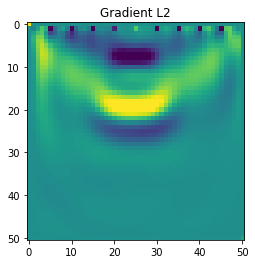

In [24]:
with tf.GradientTape() as tape:
  Pmod=fd(P,C,dt_mod,dx)
  Res=Pobs-Pmod

  A=tf.signal.rfft(Pobs)
  B=tf.signal.rfft(Pmod)

  p_msk = np.zeros([ns,nx,nz,nt],dtype=np.float32)
  p_msk_z = np.zeros([ns,nx,nz,round(nt/2)+1],dtype=np.complex64)
  p_msk[:,:,1,:]=1##s-x-z-t
  p_msk_z[:,:,1,:]=1##s-x-z-f
  Pmask = tf.Variable(p_msk)
  Pmask_z = tf.Variable(p_msk_z)

  gradmode=0

  ##STANDARD RESIDUAL L2
  if gradmode==0:
      loss=tf.reduce_mean(Pmask_z*(A-B)*tf.math.conj(A-B))
      plt.title('Gradient L2')

  ##STANDARD RESIDUAL L1 ?
  if gradmode==1:
      loss=tf.reduce_mean(tf.math.abs(Pmask_z*(A-B)))
      plt.title('Gradient L1')

  ##CROSS-CORRELATION (TO MAXIMIZE)
  if gradmode==2:
      CC=Pmask_z*(A)*tf.math.conj(B)
      loss=tf.reduce_mean(tf.math.abs(CC))
      clip=0.001
      plt.title('Cross-correlation based gradient')

  #PHASE ONLY (Alkhalifah & Yunseok Choi 2012)
  if gradmode==3:
      A=(A-tf.roll(A,shift=1,axis=3))*tf.math.conj(A)/(tf.math.conj(A)*A+0.01)
      B=(B-tf.roll(B,shift=1,axis=3))*tf.math.conj(B)/(tf.math.conj(B)*B+0.01)
      loss=tf.reduce_mean(tf.math.real(Pmask_z)*tf.math.abs(A-B))
      plt.title('gradient using only phase mismatch')

grad=tape.gradient(loss,C)
print(grad.shape)
im1=plt.imshow(np.real(np.transpose(grad.numpy())),aspect='equal')
im1.set_clim(-clip*np.max(np.abs(grad.numpy())),clip*np.max(np.abs(grad.numpy())))
plt.show()

